In [8]:
#---------------------------------
# Connect to processed data from DataPreparation
#---------------------------------

from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Path to the same base directory you used in dataprep.ipynb
BASE_PATH = Path(r"C:\CAEE Hackthon")  # <-- match dataprep
CATALOG_PATH = BASE_PATH / "processed_data" / "data_catalog.json"

# Choose community
COMMUNITY_NAME = "quinhagak"  # or any key from catalog["communities"]

with open(CATALOG_PATH, "r") as f:
    catalog = json.load(f)

entry = catalog["communities"][COMMUNITY_NAME]

ndwi_path = Path(entry["ndwi_path"])
water_mask_path = Path(entry["water_mask_path"])

print("Using:")
print(f"  NDWI:       {ndwi_path}")
print(f"  Water mask: {water_mask_path}")


Using:
  NDWI:       C:\CAEE Hackthon\processed_data\water_masks\quinhagak_ndwi.tif
  Water mask: C:\CAEE Hackthon\processed_data\water_masks\quinhagak_water_mask.tif


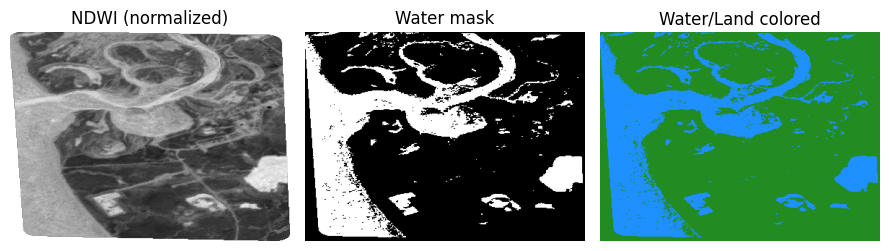

In [9]:
#---------------------------------
# Load NDWI and water mask from DataPreparation outputs
#---------------------------------

# NDWI raster (float) → use as grayscale image
with rasterio.open(ndwi_path) as src:
    ndwi = src.read(1).astype(np.float32)
    ndwi_min = float(np.nanmin(ndwi))
    ndwi_max = float(np.nanmax(ndwi))
    g = (ndwi - ndwi_min) / (ndwi_max - ndwi_min + 1e-8)   # 0–1 normalized

# Binary water mask (0 / 1) → label
with rasterio.open(water_mask_path) as src:
    mask_water = src.read(1).astype(np.uint8)

# Class IDs for erosion model: 0 = water, 4 = land
WATER, LAND = 0, 4
grid_classes = np.where(mask_water == 1, WATER, LAND).astype(np.uint8)

# Colored preview
H, W = grid_classes.shape
color = np.zeros((H, W, 3), dtype=np.uint8)
blue  = np.array([30, 144, 255], dtype=np.uint8)   # water
green = np.array([34, 139, 34],  dtype=np.uint8)   # land
color[grid_classes == WATER] = blue
color[grid_classes == LAND]  = green

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(g, cmap="gray"); plt.title("NDWI (normalized)"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask_water, cmap="gray", vmin=0, vmax=1); plt.title("Water mask"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(color); plt.title("Water/Land colored"); plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig("ndwi_watermask_preview.png", dpi=150, bbox_inches='tight')
plt.close()


In [10]:
'''#FULL CODE BELOW:

#---------------------------------
#Satellite Image to grid conversion
#---------------------------------

import matplotlib.pyplot as plt
import imageio.v2 as imageio

# load imported image as grayscale
gray = imageio.imread("testrun.png")  
if gray.ndim == 3:
    gray = (0.299*gray[...,0] + 0.587*gray[...,1] + 0.114*gray[...,2])

g = gray.astype(np.float32)
g_min, g_max = float(np.nanmin(g)), float(np.nanmax(g))
g = (g - g_min) / (g_max - g_min + 1e-8)

# defining threshold
#fixed threshold (darker -> water).
th = 0.2

# OTHER OPTION Otsu automatic threshold, to be used if larger implementation does not work well with fixed threshold
#from skimage.filters import threshold_otsu
#th = float(threshold_otsu(g[np.isfinite(g)]))

# binary mask: 1=water (dark), 0=land (light)
mask_water = (g <= th).astype(np.uint8)

# class IDs for erosion model: 0=water, 4=land
WATER, LAND = 0, 4
grid_classes = np.where(mask_water == 1, WATER, LAND).astype(np.uint8)

# create colored visualization: blue = water, green = land , CAN BE CHANGED TO BLUE AND YELLOW , like erosion model
H, W = grid_classes.shape
color = np.zeros((H, W, 3), dtype=np.uint8)
blue  = np.array([30, 144, 255], dtype=np.uint8)   # water
green = np.array([34, 139, 34],  dtype=np.uint8)   # land
color[grid_classes == WATER] = blue
color[grid_classes == LAND]  = green

# Preview
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(g, cmap="gray"); plt.title("Grayscale"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask_water, cmap="gray", vmin=0, vmax=1); plt.title(f"Mask (th={th:.2f})"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(color); plt.title("Water/Land colored"); plt.axis('off')
plt.tight_layout(); plt.savefig("threshold_recolor_preview.png", dpi=150, bbox_inches='tight'); 
plt.close()
#plt.show()

#---------------------------------
#Grid erosion model, can adjust erosion probability directly below
#---------------------------------

from matplotlib.colors import LinearSegmentedColormap

SIZE = 100                # CHANGE HERE for final resolution
EROSION_PROB = 0.4        #can be adjusted
WATER, ERODING_3, ERODING_2, ERODING_1, LAND = 0, 1, 2, 3, 4

def downsample_majority(labels, out_size):
    h, w = labels.shape
    ys = np.linspace(0, h, out_size+1).astype(int)
    xs = np.linspace(0, w, out_size+1).astype(int)
    out = np.zeros((out_size, out_size), dtype=labels.dtype)
    for i in range(out_size):
        for j in range(out_size):
            block = labels[ys[i]:ys[i+1], xs[j]:xs[j+1]]
            if block.size == 0:
                out[i, j] = LAND
            else:
                water_count = np.count_nonzero(block == WATER)
                land_count  = np.count_nonzero(block == LAND)
                out[i, j] = WATER if water_count > land_count else LAND
    return out

# Initialize grid from thresholded classes
if SIZE == g.shape[0] and SIZE == g.shape[1]:
    grid = grid_classes.copy()
else:
    grid = downsample_majority(grid_classes, SIZE)

# Colormap (colors from erosion_ca.py, hex can be adjusted for visibility)
colors = ['#0047ab', '#3366cc', '#6699ff', '#99ccff', '#ffcc00']  # Dark blue -> light blue -> yellow
n_bins = 5
cmap = LinearSegmentedColormap.from_list('erosion', colors, N=n_bins)

def count_water_neighbors(grid, i, j):
    count = 0
    current_state = grid[i, j]
    for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < SIZE and 0 <= nj < SIZE:
            if grid[ni, nj] < current_state:  #lower state = more eroded
                count += 1
    return count

def update_grid(grid):
    new_grid = grid.copy()
    for i in range(SIZE):
        for j in range(SIZE):
            if grid[i, j] > WATER:
                eroded_neighbors = count_water_neighbors(grid, i, j)
                if eroded_neighbors > 0:
                    prob = EROSION_PROB * eroded_neighbors / 4.0
                    if np.random.random() < prob:
                        new_grid[i, j] = grid[i, j] - 1
    return new_grid

#Simulate and visualize
steps = 25
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for step in range(steps):
    if step < 10:
        ax = axes[step]
        ax.imshow(grid, cmap=cmap, vmin=WATER, vmax=LAND, interpolation='nearest')
        ax.set_title(f'Step {step}')
        ax.axis('off')
    grid = update_grid(grid)

plt.tight_layout()
plt.savefig('erosion_simulation.png', dpi=150, bbox_inches='tight')
print("Simulation complete! Check 'erosion_simulation.png'")
plt.show()
'''


'#FULL CODE BELOW:\n\n#---------------------------------\n#Satellite Image to grid conversion\n#---------------------------------\n\nimport matplotlib.pyplot as plt\nimport imageio.v2 as imageio\n\n# load imported image as grayscale\ngray = imageio.imread("testrun.png")  \nif gray.ndim == 3:\n    gray = (0.299*gray[...,0] + 0.587*gray[...,1] + 0.114*gray[...,2])\n\ng = gray.astype(np.float32)\ng_min, g_max = float(np.nanmin(g)), float(np.nanmax(g))\ng = (g - g_min) / (g_max - g_min + 1e-8)\n\n# defining threshold\n#fixed threshold (darker -> water).\nth = 0.2\n\n# OTHER OPTION Otsu automatic threshold, to be used if larger implementation does not work well with fixed threshold\n#from skimage.filters import threshold_otsu\n#th = float(threshold_otsu(g[np.isfinite(g)]))\n\n# binary mask: 1=water (dark), 0=land (light)\nmask_water = (g <= th).astype(np.uint8)\n\n# class IDs for erosion model: 0=water, 4=land\nWATER, LAND = 0, 4\ngrid_classes = np.where(mask_water == 1, WATER, LAND).astype